In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def get_data(num_samples=3000):
    X = np.random.randint(0, 2, size=(num_samples, 12))
    Y = np.logical_xor(X[:, 0], X[:, 1]).astype(int)

    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.LongTensor(Y)

    return X_tensor, Y_tensor

X, Y = get_data(5)
print(f"Sample Input (X): {X[0].numpy()}")
print(f"Sample Label (Y): {Y[0].item()}")

Sample Input (X): [0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.]
Sample Label (Y): 0


We use Shannon Entropy : Discretize the neural activity so that we can use information theory concepts with neural networks.

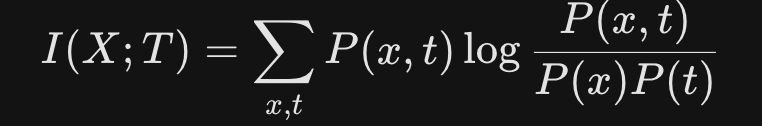

In [ ]:
def calc_layer_mutual_information(activations, targets, bins=30):

    if len(targets.shape) == 1:
        targets = targets.reshape(-1, 1)

    num_neurons = activations.shape[1]
    num_targets = targets.shape[1]

    total_mi = 0


    for i in range(num_neurons):
        neuron_vals = activations[:, i]
        for j in range(num_targets):
            target_vals = targets[:, j]


            joint_prob, _, _ = np.histogram2d(neuron_vals, target_vals, bins=bins)
            joint_prob = joint_prob / np.sum(joint_prob)

            p_t = np.sum(joint_prob, axis=1)
            p_target = np.sum(joint_prob, axis=0)

            mi = 0
            for r in range(joint_prob.shape[0]):
                for c in range(joint_prob.shape[1]):
                    if joint_prob[r, c] > 0:
                        mi += joint_prob[r, c] * np.log2(joint_prob[r, c] / (p_t[r] * p_target[c]))

            total_mi += mi

    return total_mi / (num_neurons * num_targets)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.fc1 = nn.Linear(12, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)

        t_layer = self.fc2(x)
        t_activation = self.relu(t_layer)


        output = self.fc3(t_activation)

        return output, t_activation

net = SimpleNet()
print(net)

SimpleNet(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
net = SimpleNet()
optimizer = optim.SGD(net.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()
X, Y = get_data(num_samples=3000)

info_plane_history = []

print("Starting the Experiment...")

for epoch in range(100):

    outputs, t_state = net(X)

    t_numpy = t_state.detach().numpy()
    x_numpy = X.numpy()
    y_numpy = Y.numpy()

    mi_xt = calc_layer_mutual_information(t_numpy, x_numpy, bins=30)

    mi_ty = calc_layer_mutual_information(t_numpy, y_numpy, bins=30)

    info_plane_history.append((mi_xt, mi_ty))

    loss = criterion(outputs, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f} | I(X;T): {mi_xt:.4f} | I(T;Y): {mi_ty:.4f}")

print("Experiment Complete.")

Starting the Experiment...
Epoch 0: Loss 0.6939 | I(X;T): 0.0503 | I(T;Y): 0.0163
Epoch 10: Loss 0.6931 | I(X;T): 0.0503 | I(T;Y): 0.0166
Epoch 20: Loss 0.6922 | I(X;T): 0.0503 | I(T;Y): 0.0169
Epoch 30: Loss 0.6914 | I(X;T): 0.0504 | I(T;Y): 0.0167
Epoch 40: Loss 0.6906 | I(X;T): 0.0504 | I(T;Y): 0.0167
Epoch 50: Loss 0.6897 | I(X;T): 0.0505 | I(T;Y): 0.0170
Epoch 60: Loss 0.6888 | I(X;T): 0.0505 | I(T;Y): 0.0172
Epoch 70: Loss 0.6878 | I(X;T): 0.0506 | I(T;Y): 0.0172
Epoch 80: Loss 0.6867 | I(X;T): 0.0507 | I(T;Y): 0.0183
Epoch 90: Loss 0.6854 | I(X;T): 0.0508 | I(T;Y): 0.0188
Experiment Complete.


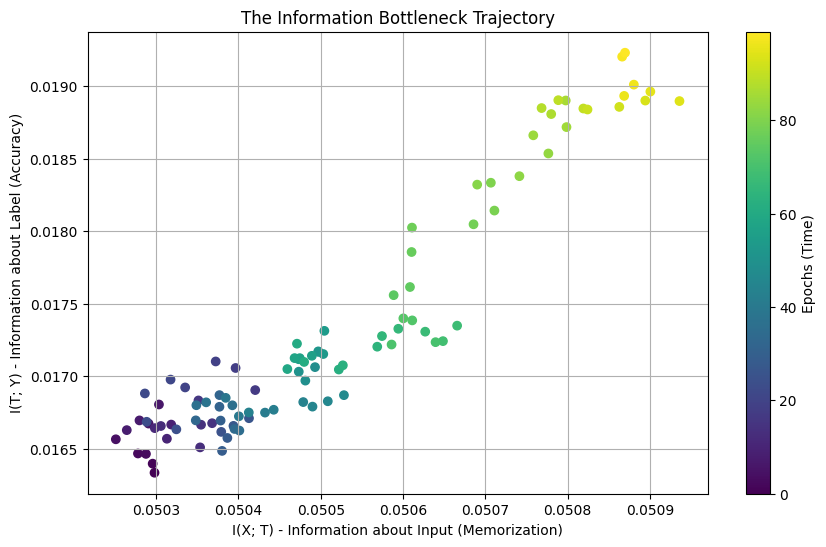

In [ ]:
import matplotlib.pyplot as plt

mi_xt_vals = [x[0] for x in info_plane_history]
mi_ty_vals = [x[1] for x in info_plane_history]

plt.figure(figsize=(10, 6))
plt.scatter(mi_xt_vals, mi_ty_vals, c=range(len(info_plane_history)), cmap='viridis')
plt.colorbar(label='Epochs (Time)')
plt.xlabel('I(X; T) - Information about Input (Memorization)')
plt.ylabel('I(T; Y) - Information about Label (Accuracy)')
plt.title('The Information Bottleneck Trajectory')
plt.grid(True)
plt.show()

In [ ]:
class StochasticNet(nn.Module):
    def __init__(self, noise_std=0.5):
        super(StochasticNet, self).__init__()
        self.fc1 = nn.Linear(12, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

        self.noise_std = noise_std

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        t_layer = self.fc2(x)
        t_activation = self.relu(t_layer)

        if self.training:

            noise = torch.randn_like(t_activation) * self.noise_std
            t_noisy = t_activation + noise
        else:
            t_noisy = t_activation

        output = self.fc3(t_noisy)


        return output, t_noisy

stochastic_net = StochasticNet(noise_std=0.5)
print(stochastic_net)

StochasticNet(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
X, Y = get_data(num_samples=3000)
optimizer = optim.SGD(stochastic_net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

stochastic_history = []

print("Starting Stochastic Experiment...")

for epoch in range(150):
    stochastic_net.train()
    outputs, t_state = stochastic_net(X)

    t_numpy = t_state.detach().numpy()
    x_numpy = X.numpy()
    y_numpy = Y.numpy()

    mi_xt = calc_layer_mutual_information(t_numpy, x_numpy, bins=30)
    mi_ty = calc_layer_mutual_information(t_numpy, y_numpy, bins=30)

    stochastic_history.append((mi_xt, mi_ty))
    loss = criterion(outputs, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f} | I(X;T): {mi_xt:.4f} | I(T;Y): {mi_ty:.4f}")

print("Done.")

Starting Stochastic Experiment...
Epoch 0: Loss 0.7175 | I(X;T): 0.0083 | I(T;Y): 0.0073
Epoch 10: Loss 0.7013 | I(X;T): 0.0084 | I(T;Y): 0.0072
Epoch 20: Loss 0.6974 | I(X;T): 0.0082 | I(T;Y): 0.0074
Epoch 30: Loss 0.6964 | I(X;T): 0.0083 | I(T;Y): 0.0076
Epoch 40: Loss 0.6971 | I(X;T): 0.0082 | I(T;Y): 0.0070
Epoch 50: Loss 0.6923 | I(X;T): 0.0083 | I(T;Y): 0.0073
Epoch 60: Loss 0.6905 | I(X;T): 0.0083 | I(T;Y): 0.0076
Epoch 70: Loss 0.6878 | I(X;T): 0.0083 | I(T;Y): 0.0075
Epoch 80: Loss 0.6895 | I(X;T): 0.0083 | I(T;Y): 0.0077
Epoch 90: Loss 0.6894 | I(X;T): 0.0084 | I(T;Y): 0.0076
Epoch 100: Loss 0.6783 | I(X;T): 0.0084 | I(T;Y): 0.0073
Epoch 110: Loss 0.6752 | I(X;T): 0.0085 | I(T;Y): 0.0076
Epoch 120: Loss 0.6688 | I(X;T): 0.0084 | I(T;Y): 0.0084
Epoch 130: Loss 0.6697 | I(X;T): 0.0084 | I(T;Y): 0.0078
Epoch 140: Loss 0.6514 | I(X;T): 0.0085 | I(T;Y): 0.0084
Done.


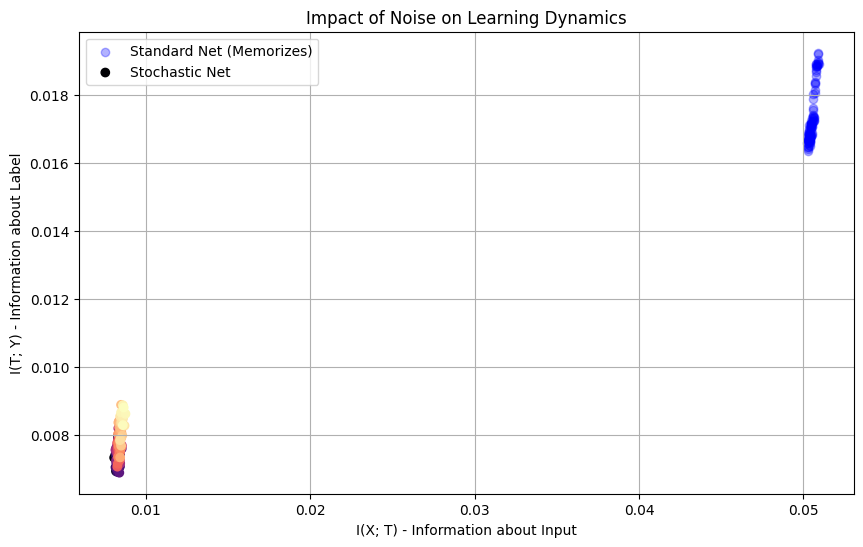

In [ ]:
stoch_xt = [x[0] for x in stochastic_history]
stoch_ty = [x[1] for x in stochastic_history]

det_xt = [x[0] for x in info_plane_history]
det_ty = [x[1] for x in info_plane_history]

plt.figure(figsize=(10, 6))
plt.scatter(det_xt, det_ty, color='blue', alpha=0.3, label='Standard Net (Memorizes)')
plt.scatter(stoch_xt, stoch_ty, c=range(len(stochastic_history)), cmap='magma', label='Stochastic Net')

plt.xlabel('I(X; T) - Information about Input')
plt.ylabel('I(T; Y) - Information about Label')
plt.title('Impact of Noise on Learning Dynamics')
plt.legend()
plt.grid(True)
plt.show()

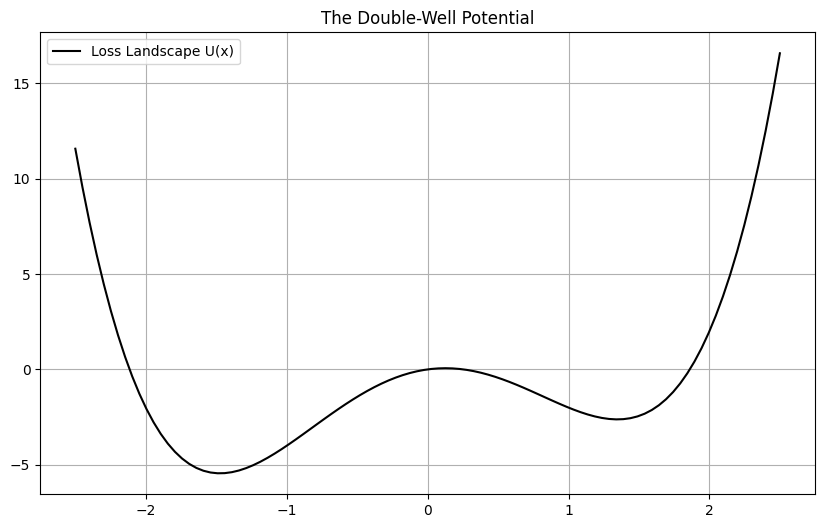

In [ ]:
#Lagevin Dynamics
#Euler-Maruyama Method
#Using noise to find answers

import numpy as np
import matplotlib.pyplot as plt
def U(x):
    return x**4 - 4*x**2 + x
def grad_U(x):
    return 4*x**3 - 8*x + 1

x_grid = np.linspace(-2.5, 2.5, 100)
plt.figure(figsize=(10, 6))
plt.plot(x_grid, U(x_grid), 'k-', label='Loss Landscape U(x)')
plt.title("The Double-Well Potential")
plt.grid(True)
plt.legend()
plt.show()

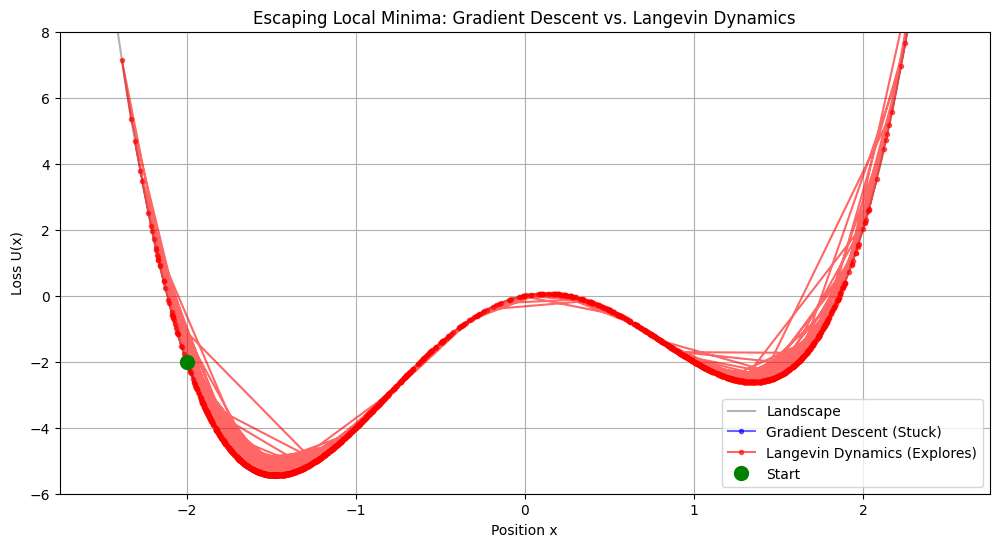

Gradient Descent Final Position: -1.4730
Langevin Final Position: 1.1209


In [ ]:
def optimize(algorithm_type, start_x, n_steps=1000, eta=0.01, temperature=0.0):
    trajectory = [start_x]
    x = start_x

    #using the Euler-maruyama method
    for _ in range(n_steps):
        force = -grad_U(x)
        if algorithm_type == 'Langevin':
            noise = np.sqrt(2 * eta * temperature) * np.random.randn()
        else:
            noise = 0.0
            x = x + (eta * force) + noise
        trajectory.append(x)

    return np.array(trajectory)

start_pos = -2.0
steps = 2000
lr = 0.01
traj_gd = optimize('GD', start_pos, n_steps=steps, eta=lr, temperature=0.0)


traj_langevin = optimize('Langevin', start_pos, n_steps=steps, eta=lr, temperature=2.0)
plt.figure(figsize=(12, 6))
plt.plot(x_grid, U(x_grid), 'k-', alpha=0.3, label='Landscape')

plt.plot(traj_gd, U(traj_gd), 'b.-', alpha=0.6, label='Gradient Descent (Stuck)')

plt.plot(traj_langevin, U(traj_langevin), 'r.-', alpha=0.6, label='Langevin Dynamics (Explores)')

plt.plot(start_pos, U(start_pos), 'go', markersize=10, label='Start')

plt.ylim(-6, 8)
plt.title("Escaping Local Minima: Gradient Descent vs. Langevin Dynamics")
plt.xlabel("Position x")
plt.ylabel("Loss U(x)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Gradient Descent Final Position: {traj_gd[-1]:.4f}")
print(f"Langevin Final Position: {traj_langevin[-1]:.4f}")

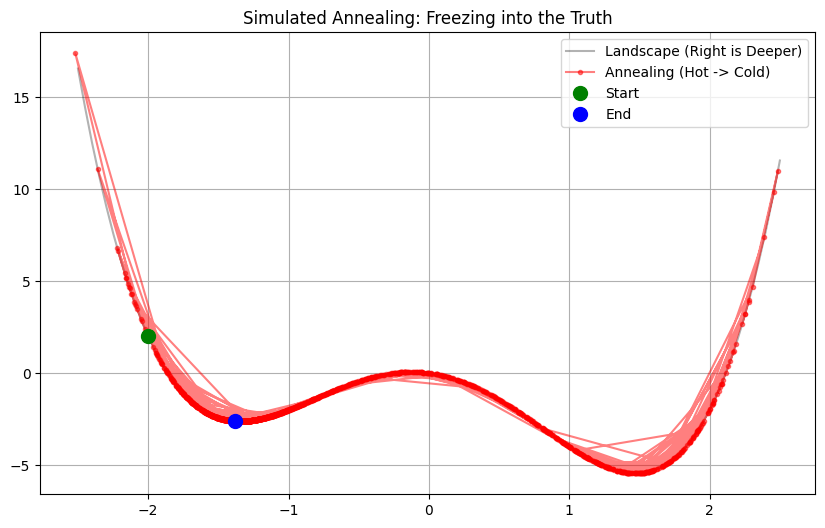

In [ ]:

def U(x):
    return x**4 - 4*x**2 - x

def grad_U(x):
    return 4*x**3 - 8*x - 1

def optimize_annealing(start_x, n_steps=2000, start_temp=4.0):
    trajectory = [start_x]
    x = start_x

    for step in range(n_steps):
        current_temp = start_temp * (1 - (step / n_steps))
        current_temp = max(current_temp, 0.0)

        force = -grad_U(x)
        noise = np.sqrt(2 * 0.01 * current_temp) * np.random.randn()

        x = x + (0.01 * force) + noise
        trajectory.append(x)

    return np.array(trajectory)

start_pos = -2.0

traj_anneal = optimize_annealing(start_pos)

x_grid = np.linspace(-2.5, 2.5, 100)
plt.figure(figsize=(10, 6))
plt.plot(x_grid, U(x_grid), 'k-', alpha=0.3, label='Landscape (Right is Deeper)')
plt.plot(traj_anneal, U(traj_anneal), 'r.-', alpha=0.5, label='Annealing (Hot -> Cold)')

plt.plot(start_pos, U(start_pos), 'go', markersize=10, label='Start')
plt.plot(traj_anneal[-1], U(traj_anneal[-1]), 'bo', markersize=10, label='End')

plt.title("Simulated Annealing: Freezing into the Truth")
plt.legend()
plt.grid(True)
plt.show()

Running SGLD (Bayesian Training)...
Collected 59 Bayesian Models.


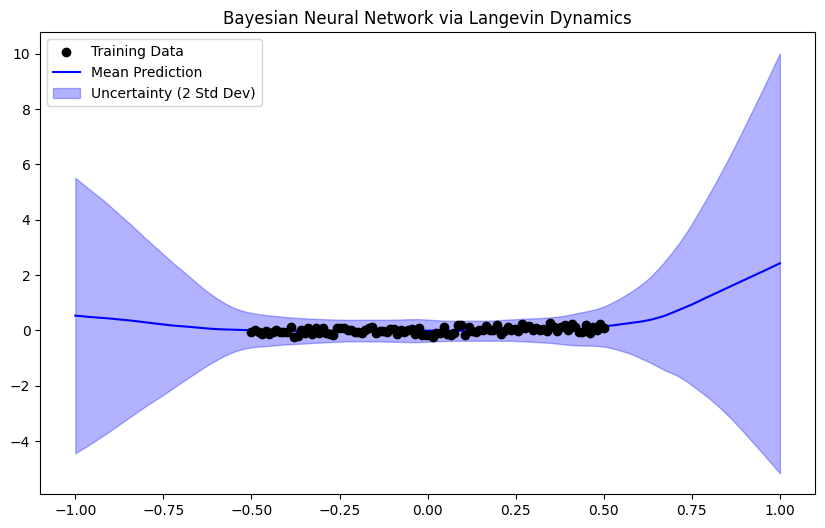

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import json

def json_deepcopy(model):
    return copy.deepcopy(model.state_dict())


def get_data(n=100):
    x = torch.linspace(-0.5, 0.5, n).reshape(-1, 1)
    y = x**3 + 0.1 * torch.randn_like(x) # True function + Noise
    return x, y

model = nn.Sequential(
    nn.Linear(1, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)


def sgld_step(model, lr=0.01, train_size=100):
    sigma = torch.sqrt(torch.tensor(2 * lr))

    for param in model.parameters():
        if param.grad is not None:
            grad_prior = param.data * 1.0
            delta_deterministic = 0.5 * (param.grad.data * train_size + grad_prior)

            noise = torch.randn_like(param.data) * sigma

            param.data.sub_(lr * delta_deterministic - noise)


X_train, Y_train = get_data()
loss_fn = nn.MSELoss()

posterior_samples = []

print("Running SGLD (Bayesian Training)...")

for step in range(5000):
    output = model(X_train)
    loss = loss_fn(output, Y_train)
    model.zero_grad()
    loss.backward()

    sgld_step(model, lr=0.001, train_size=len(X_train))
    if step > 2000 and step % 50 == 0:
        posterior_samples.append(json_deepcopy(model))

print(f"Collected {len(posterior_samples)} Bayesian Models.")





def predict_uncertainty(X_test):
    preds = []
    for state_dict in posterior_samples:
        temp_model = nn.Sequential(
            nn.Linear(1, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 1)
        )
        temp_model.load_state_dict(state_dict)
        with torch.no_grad():
            preds.append(temp_model(X_test).numpy())

    preds = np.array(preds)
    mean_pred = preds.mean(axis=0)
    std_pred = preds.std(axis=0)
    return mean_pred, std_pred


X_test = torch.linspace(-1.0, 1.0, 200).reshape(-1, 1)
mean, std = predict_uncertainty(X_test)


plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, c='black', label='Training Data', zorder=5)
plt.plot(X_test, mean, 'b-', label='Mean Prediction')


plt.fill_between(X_test.flatten(),
                 (mean - 2*std).flatten(),
                 (mean + 2*std).flatten(),
                 color='blue', alpha=0.3, label='Uncertainty (2 Std Dev)')

plt.title("Bayesian Neural Network via Langevin Dynamics")
plt.legend()
plt.show()

# Minimax Optimization and Adversarial Dynamics


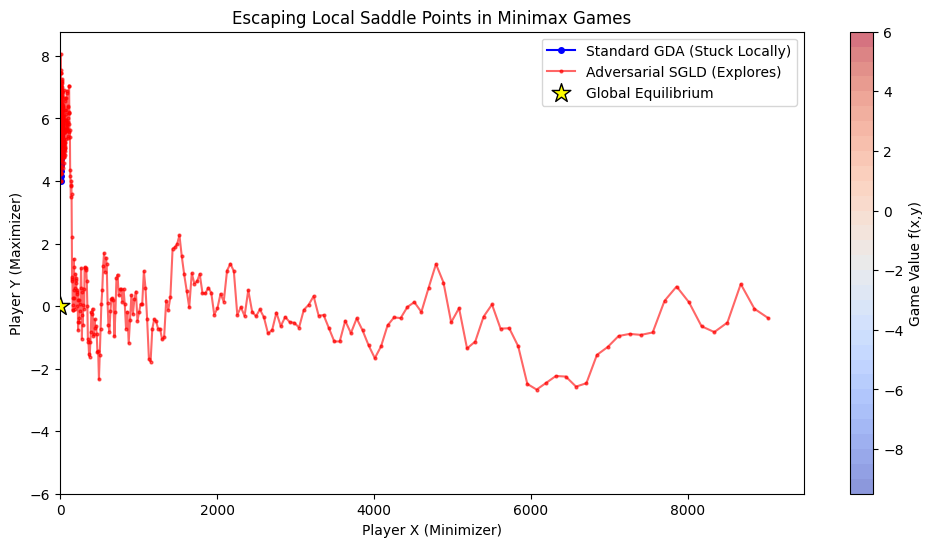

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def f(x, y):
    return 3*np.sin(x) + 3*np.cos(y) - 0.1*x**2 - 0.1*y**2


def get_gradients(x, y):
    grad_x = 3*np.cos(x) - 0.2*x
    grad_y = -3*np.sin(y) - 0.2*y
    return grad_x, grad_y


def optimize_game(mode, n_steps=500, lr=0.1, temp=0.0):
    x, y = 4.0, 4.0

    trajectory = []

    for _ in range(n_steps):
        trajectory.append((x, y))

        gx, gy = get_gradients(x, y)

        if mode == 'SGLD':
            noise_scale = np.sqrt(2 * lr * temp)
            nx = noise_scale * np.random.randn()
            ny = noise_scale * np.random.randn()
        else:
            nx, ny = 0.0, 0.0

        x = x - lr * gx + nx
        y = y + lr * gy + ny

    return np.array(trajectory)


xx = np.linspace(-6, 6, 100)
yy = np.linspace(-6, 6, 100)
X_grid, Y_grid = np.meshgrid(xx, yy)
Z = f(X_grid, Y_grid)

plt.figure(figsize=(12, 6))

plt.contourf(X_grid, Y_grid, Z, levels=30, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Game Value f(x,y)')


# 1. Standard Gradient Descent/Ascent (No Noise)
traj_gda = optimize_game('GDA', n_steps=200, lr=0.1, temp=0.0)
plt.plot(traj_gda[:,0], traj_gda[:,1], 'b-o', markersize=4, label='Standard GDA (Stuck Locally)')


# 2. Langevin Dynamics (With Noise)
traj_sgld = optimize_game('SGLD', n_steps=500, lr=0.1, temp=1.5) # High temp to escape
plt.plot(traj_sgld[:,0], traj_sgld[:,1], 'r-o', markersize=2, alpha=0.6, label='Adversarial SGLD (Explores)')


plt.scatter([-1.4], [0], c='yellow', s=200, marker='*', edgecolors='black', label='Global Equilibrium', zorder=10)

plt.title("Escaping Local Saddle Points in Minimax Games")
plt.xlabel("Player X (Minimizer)")
plt.ylabel("Player Y (Maximizer)")
plt.legend()
plt.show()